# Text to Multiclass Explanation: Emotion Classification Example

This notebook demonstrates how to use the partition explainer for multiclass scenario with text data and visualize feature attributions towards individual classes. For computing shap values for a multiclass scenario, it uses the partition explainer over the text data and computes attribution for a feature towards a given class based on its marginal contribution towards the difference in the one vs all logit for the respective class from its base value. 

Below we walkthrough an example demonstrating explanation of a text classfication model (https://huggingface.co/nateraw/bert-base-uncased-emotion) which in this case is BERT fine-tuned on the emotion dataset (https://huggingface.co/datasets/emotion) provided by hugging face to classify a sentence among six classes of emotions: joy, sadness, anger, fear, love and surprise.

In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import shap
import scipy as sp
import nlp
import torch

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

### Load data

In [3]:
train, test = nlp.load_dataset("emotion", split = ["train", "test"])

WARNING - Using custom data configuration default


In [4]:
data={'text':train['text'],
     'emotion':train['label']}
        
data = pd.DataFrame(data)

In [5]:
data.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love
4,i am feeling grouchy,anger


### Distribution of emotion labels

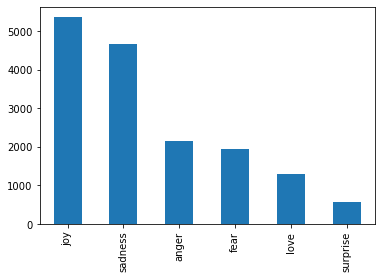

In [6]:
ax = data.emotion.value_counts().plot.bar()

### Load model and tokenizer

In [7]:
tokenizer = AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion",use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion").cuda()

In [8]:
# set mapping between label and id
id2label = model.config.id2label
label2id = model.config.label2id
labels = sorted(label2id, key=label2id.get)

### Define function

In [9]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128,truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores) 
    return val

### Create an explainer object

In [10]:
explainer = shap.Explainer(f,tokenizer,output_names=labels)

explainers.Partition is still in an alpha state, so use with caution...


### Compute SHAP values

In [11]:
shap_values = explainer(data['text'][0:50])

Partition explainer: 51it [01:02,  1.22s/it]                                                                           


### Custom plotting of SHAP values

In [12]:
def custom_masked_bar_plot(class_index,mask_type,viz_type):
    #determine type of operation on the explanation object
    if viz_type=='mean':
        compute_shap=copy.copy(shap_values.mean(0))
    if viz_type=='sum':
        compute_shap=copy.copy(shap_values.sum(0))
    if viz_type=='abs_mean':
        compute_shap=copy.copy(shap_values.abs.sum(0))
    if viz_type=='abs_sum':
        compute_shap=copy.copy(shap_values.abs.sum(0))
    #create a mask to visualize either positively or negatively contributing features
    if mask_type=='pos':
        mask=compute_shap.values[:,class_index]>=0
    else:
        mask=compute_shap.values[:,class_index]<=0
    #slice values related to a given class
    compute_shap.values=compute_shap.values[:,class_index][mask]
    compute_shap.feature_names=list(np.array(compute_shap.feature_names)[mask])
    #plot
    shap.plots.bar(compute_shap.abs,order=shap.Explanation.identity)

### Top words contributing to emotion class: joy

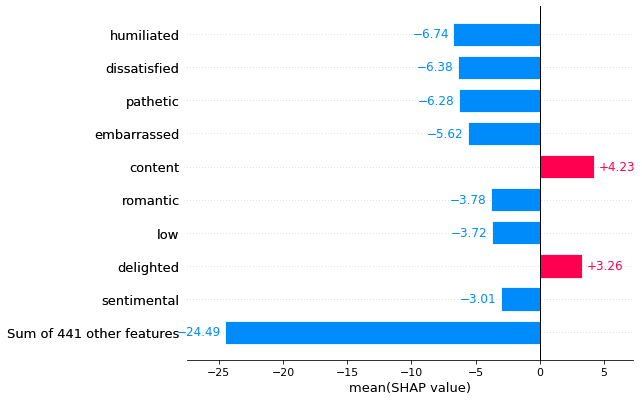

In [13]:
shap.plots.bar(shap_values.mean(0)[:,label2id['joy']])

### Top words positively contributing to emotion class: joy

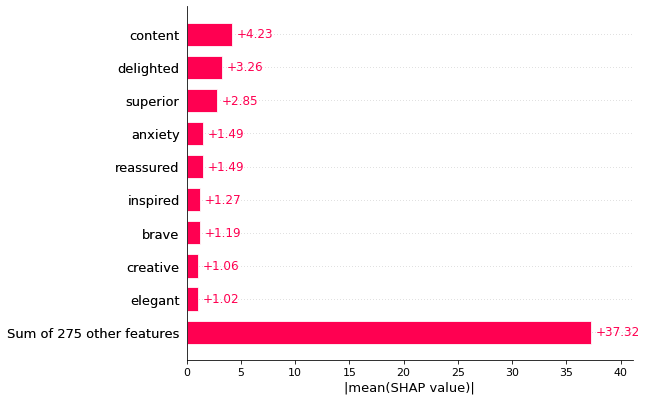

In [14]:
custom_masked_bar_plot(label2id["joy"],'pos','mean')

### Top words negatively contributing to emotion class: joy

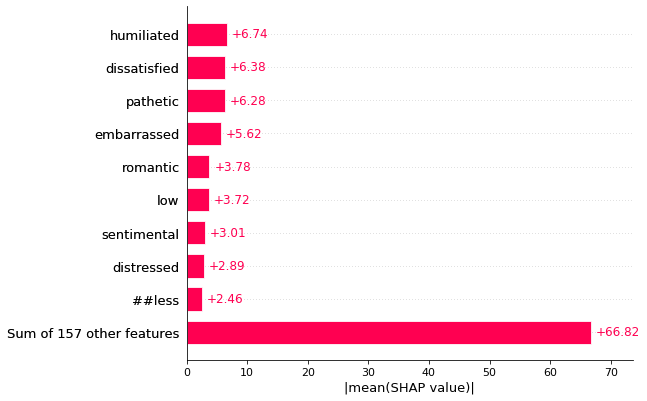

In [15]:
custom_masked_bar_plot(label2id["joy"],'neg','mean')

### Top words positively contributing to emotion class: surprise

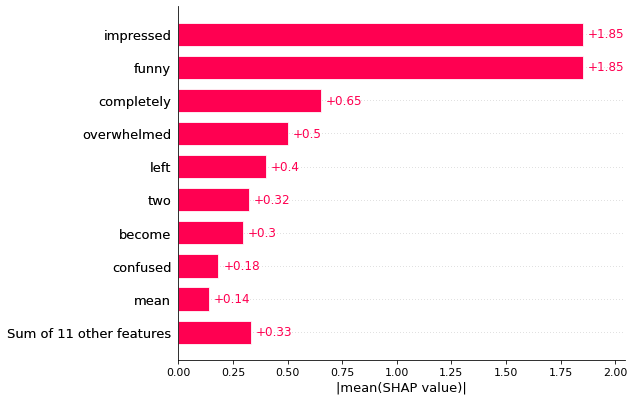

In [16]:
custom_masked_bar_plot(label2id["surprise"],'pos','mean')

### Top words negatively contributing to emotion class: surprise

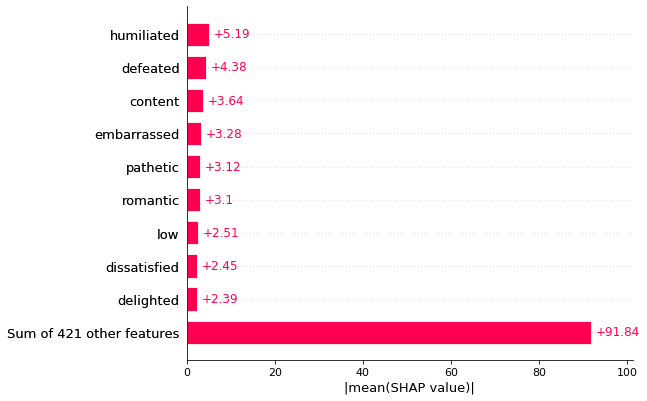

In [17]:
custom_masked_bar_plot(label2id["surprise"],'neg','mean')

### Top words positively contributing to emotion class: anger

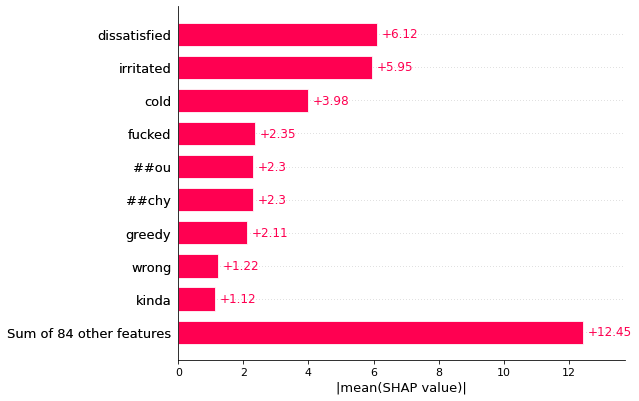

In [18]:
custom_masked_bar_plot(label2id["anger"],'pos','mean')

### Top words negatively contributing to emotion class: anger

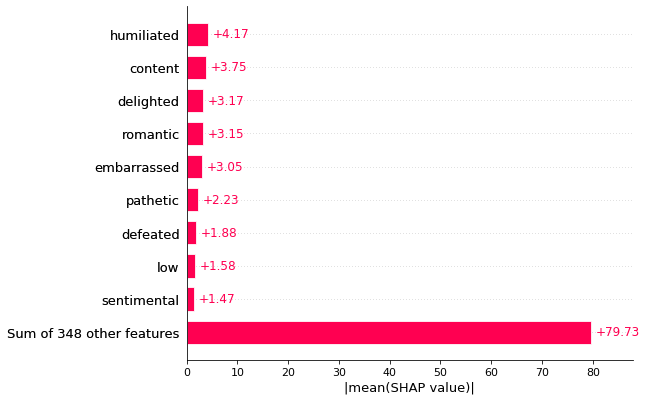

In [19]:
custom_masked_bar_plot(label2id["anger"],'neg','mean')

### Visualizing text plots over attribution of features towards a given class

In [20]:
index = 0
shap.plots.text(shap_values[index:index+1])

,,i,didnt,feel,humiliated,
sadness,-0.0,0.16,0.249,0.201,6.901,-0.0
joy,0.0,-0.055,0.238,0.511,-6.736,0.0
love,0.0,-0.115,-0.356,-0.07,-4.673,0.0
anger,-0.0,-0.05,-0.289,-1.233,-4.175,-0.0
fear,0.0,-0.278,0.259,-0.685,-4.298,0.0
surprise,0.0,-0.185,-0.489,-0.437,-5.187,0.0
